# Lidar pointcloud analysis using laserfarm

In this tutorial, we demonstrate an example of analysing AHN3 pointcloud data using the `laserfarm` package.

Laserfarm (Laserchicken Framework for Applications in Research in Macro-ecology) provides a FOSS wrapper to Laserchicken supporting the use of massive LiDAR point cloud data sets for macro-ecology, from data preparation to scheduling and execution of distributed processing across a cluster of compute nodes.

### The dataset

AHN (Actueel Hoogtebestand Nederland) is a digtal height dataset of the Netherlands, measured with laser altimetry. The [AHN3](https://www.pdok.nl/introductie/-/article/actueel-hoogtebestand-nederland-ahn3-) dataset, which is used in this tutorial, is the third update of this dataset. 

AHN3 is a public dataset and is free from copyright restrictions. Please refer to [this link](https://data.overheid.nl/en/dataset/11513-actueel-hoogtebestand-nederland-3--ahn3-) for the license status of AHN3.

In [1]:
import json
import os
import pathlib
                    
from dask.distributed import LocalCluster
from laserfarm import Retiler, DataProcessing, GeotiffWriter, MacroPipeline

## Setup a Dask cluster

In this tutorial, we will use a Dask cluster for all the macro-pipeline calculations.

In [2]:
local_tmp = pathlib.Path('./tmp')
cluster = LocalCluster(processes=True, 
                       n_workers=2, 
                       threads_per_worker=1, 
                       local_directory=local_tmp/'dask-worker-space')

cluster

LocalCluster(02595308, 'tcp://127.0.0.1:35707', workers=2, threads=2, memory=7.66 GiB)

## Step1: Retiling
The first step in the pipeline is to retile the point-cloud files to a regular grid, splitting the original data into smaller chuncks that are easier to handle for data processing.

First we will set the relavant path of this step:

In [3]:
# Path to the input AHN3 data
path_ahn = pathlib.Path('../data/')

# Set the output path
path_retiled = pathlib.Path('./retiling/retiling_out/')

Then we will set the boundaries of the grid and the number of tiles along each axis. Here we give RD coordinates of the data of interest. 

Here we set the `n_tiles_side` to 2, then 2x2=4 tiles will be created. Note that if the grid boundaries are within the actual dataset, extra tiles outside the boundary will be created.

In [4]:
# Define the retiling grid
grid = {
    'min_x': 88500,
    'max_x': 88800,
    'min_y': 458400,
    'max_y': 458700,
    'n_tiles_side': 2
}

Now we set up a dictionary defining the configuration of the retiling step. There are four substeps here:

- setup_local_fs: specify the local file paths
- set_grid: set the retiling grid
- split_and_redistribute: split the pointcloud file in the data directory with given grid
- validate: Validate the produced output by checking consistency in the number
        of input and output points

In [5]:
# setup input dictionary to configure the retiling pipeline
retiling_input = {
    'setup_local_fs': {'tmp_folder': local_tmp.as_posix(),
                       'input_folder': path_ahn.as_posix(),
                       'output_folder': path_retiled.as_posix()},
    'set_grid': grid,
    'split_and_redistribute': {},
    'validate': {}
}

Now we will setup the pipeline for the retiling step. Essentialy, for every input data file in `path_ahn`,  we will initiate a `Retiler` object and configure with `retiling_input`. The `Retiler` objects forms the tasks of the pipeline. The processing then can be distributed to the given cluster. 


In [6]:
# Intiate the pipline
retiling_macro = MacroPipeline()

# Get the pointcloud data files
data_files =  [f for f in path_ahn.iterdir()]
print('Retrieve and retile: {} LAZ files'.format(len(data_files)))

# Initialize Retiler per input data file, and configure. 
# Add Retiler list to macro-pipeline tasks
retiling_macro.tasks = [Retiler(file).config(retiling_input) for file in data_files]

# Set the corresponding labels
retiling_macro.set_labels([os.path.splitext(file)[0] for file in data_files])

# Set the cluster for distributing processing
retiling_macro.setup_cluster(cluster=cluster)

Retrieve and retile: 2 LAZ files


Then we can execute the pipeline, and print the outcome.

In [7]:
# run! 
retiling_macro.run()
retiling_macro.print_outcome()

001 ../data/AHN3                   finished
002 ../data/AHN3                   error: RuntimeError, Cannot determine reader for input file: ../data/../data/AHN3.log


Also, we can check the output directory and see what files are generated

In [8]:
[f for f in path_retiled.rglob('*') if f.is_file()]

[PosixPath('retiling/retiling_out/AHN3_retile_record.js'),
 PosixPath('retiling/retiling_out/tile_0_0/AHN3_1.las'),
 PosixPath('retiling/retiling_out/tile_0_1/AHN3_3.las'),
 PosixPath('retiling/retiling_out/tile_1_0/AHN3_2.las'),
 PosixPath('retiling/retiling_out/tile_1_1/AHN3_4.las')]

## Step 2: Feature Extraction

By retiling the original files to smaller tiles, we prepared the processing easier for distribution. Now, for a better understading of the poincloud, we need to investigate the common characters of multiple points within a certain range. 

To do this, we devide the poincloud into volumes. Within each volume, various statistics are computed to represent the volume. These statistics are referred as "features". In each volume, the derived features are assigned to an artificial point representing the volume, which is referred as the "target point".  

The build-in features can be extracted from `laserchicken`:

In [9]:
from laserchicken.feature_extractor.feature_extraction import list_feature_names
sorted(list_feature_names())

['band_ratio_1<normalized_height<2',
 'band_ratio_2<normalized_height<3',
 'band_ratio_3<normalized_height',
 'band_ratio_normalized_height<1',
 'coeff_var_intensity',
 'coeff_var_normalized_height',
 'coeff_var_z',
 'density_absolute_mean_normalized_height',
 'density_absolute_mean_z',
 'echo_ratio',
 'eigenv_1',
 'eigenv_2',
 'eigenv_3',
 'entropy_normalized_height',
 'entropy_z',
 'kurto_normalized_height',
 'kurto_z',
 'max_intensity',
 'max_normalized_height',
 'max_z',
 'mean_intensity',
 'mean_normalized_height',
 'mean_z',
 'median_normalized_height',
 'median_z',
 'min_intensity',
 'min_normalized_height',
 'min_z',
 'normal_vector_1',
 'normal_vector_2',
 'normal_vector_3',
 'perc_100_normalized_height',
 'perc_100_z',
 'perc_10_normalized_height',
 'perc_10_z',
 'perc_11_normalized_height',
 'perc_11_z',
 'perc_12_normalized_height',
 'perc_12_z',
 'perc_13_normalized_height',
 'perc_13_z',
 'perc_14_normalized_height',
 'perc_14_z',
 'perc_15_normalized_height',
 'perc_15_z

In this tutorial, we will compute fourt features within 10m meshgrid. 

In [10]:
# target mesh size & list of features
tile_mesh_size = 10.
features = ['perc_95_normalized_height', 
            'pulse_penetration_ratio', 
            'entropy_normalized_height', 
            'point_density']

# Ouput path of the target points
path_targets = pathlib.Path('./feature_extraction/targets/')

The input of feature extraction

As the previous step, we set up a dictionary configuring of the feature extraction step. There are seven substeps here:

- setup_local_fs: specify the local file paths
- load: load retiled data
- normalize: Normalize point cloud heights.
- generate_targets: generates target points
- extract_features: compute the features 
- export_targets: export target points into files
- clear_cache: cache cleaning

In [11]:
feature_extraction_input = {
    'setup_local_fs': {
        'input_folder': path_retiled.as_posix(),
        'output_folder': path_targets.as_posix()
    },
    'load': {},
    'normalize': {
        'cell_size': 1
    },
    'generate_targets': {
        'tile_mesh_size' : 10.0,
        'validate' : True,
        'validate_precision': 1.e-3,
        **grid
    },
    'extract_features': {
        'feature_names': features,
        'volume_type': 'cell',
        'volume_size': 10
    },
    'export_targets': {
        'attributes': features,
        'multi_band_files': False
    },
    'clear_cache': {}
}

Then we initialize a feature extraction pipeline and run.

In [12]:
# Initialize the pipeline
fe_macro = MacroPipeline()

# Determine which tiles and extract tile index numbers
tiles = [t.name for t in path_retiled.glob('tile_*_*/')]
tile_indices = [[int(n) for n in t.split('_')[1:]] for t in tiles]
print('Retrieve and process: {} tiles'.format(len(tile_indices)))

# add pipeline list to macro-pipeline object and set the corresponding labels
fe_macro.tasks = [DataProcessing(t, tile_index=idx).config(feature_extraction_input)
               for t, idx in zip(tiles, tile_indices)]
fe_macro.set_labels(tiles)

fe_macro.setup_cluster(cluster=cluster)

# run!
fe_macro.run()
fe_macro.print_outcome()

Retrieve and process: 4 tiles
001 tile_0_0                       finished
002 tile_0_1                       finished
003 tile_1_0                       finished
004 tile_1_1                       finished


Now we can also see the results of the four features are generated under `path_targets`.

In [13]:
[f for f in path_targets.rglob('*') if f.is_dir()]

[PosixPath('feature_extraction/targets/entropy_normalized_height'),
 PosixPath('feature_extraction/targets/perc_95_normalized_height'),
 PosixPath('feature_extraction/targets/point_density'),
 PosixPath('feature_extraction/targets/pulse_penetration_ratio')]

## Step 3: GeoTIFF Export

At last, we can export the extracted features from the target points to GeoTIFF files.

First we need to setup the paths and input dictionary.

In [14]:
# dCache path where to copy the GeoTIFF files
gw_out_path = pathlib.Path('./geotiffs')

# setup input dictionary to configure the GeoTIFF export pipeline
geotiff_export_input = {
    'setup_local_fs': {'input_folder': path_targets.as_posix(),
                       'output_folder': gw_out_path.as_posix()},
    'parse_point_cloud': {},
    'data_split': [1, 1],
    'create_subregion_geotiffs': {'output_handle': 'geotiff'}
}

# write input dictionary to JSON file
with open('geotiff_export.json', 'w') as f:
    json.dump(geotiff_export_input, f)

Then we can execute the pipeline to export the geotiffs. 

In [15]:
macro_geotiff = MacroPipeline()

# add pipeline list to macro-pipeline object and set the corresponding labels
macro_geotiff.tasks = [GeotiffWriter(input_dir=feature, bands=feature).config(geotiff_export_input)
               for feature in features]
macro_geotiff.set_labels(features)

macro_geotiff.setup_cluster(cluster=cluster)

# run!
macro_geotiff.run()
macro_geotiff.print_outcome()

001 perc_95_normalized_height      finished
002 pulse_penetration_ratio        finished
003 entropy_normalized_height      finished
004 point_density                  finished


We can also visualize one of the geotiff we created using `rioxarray`.

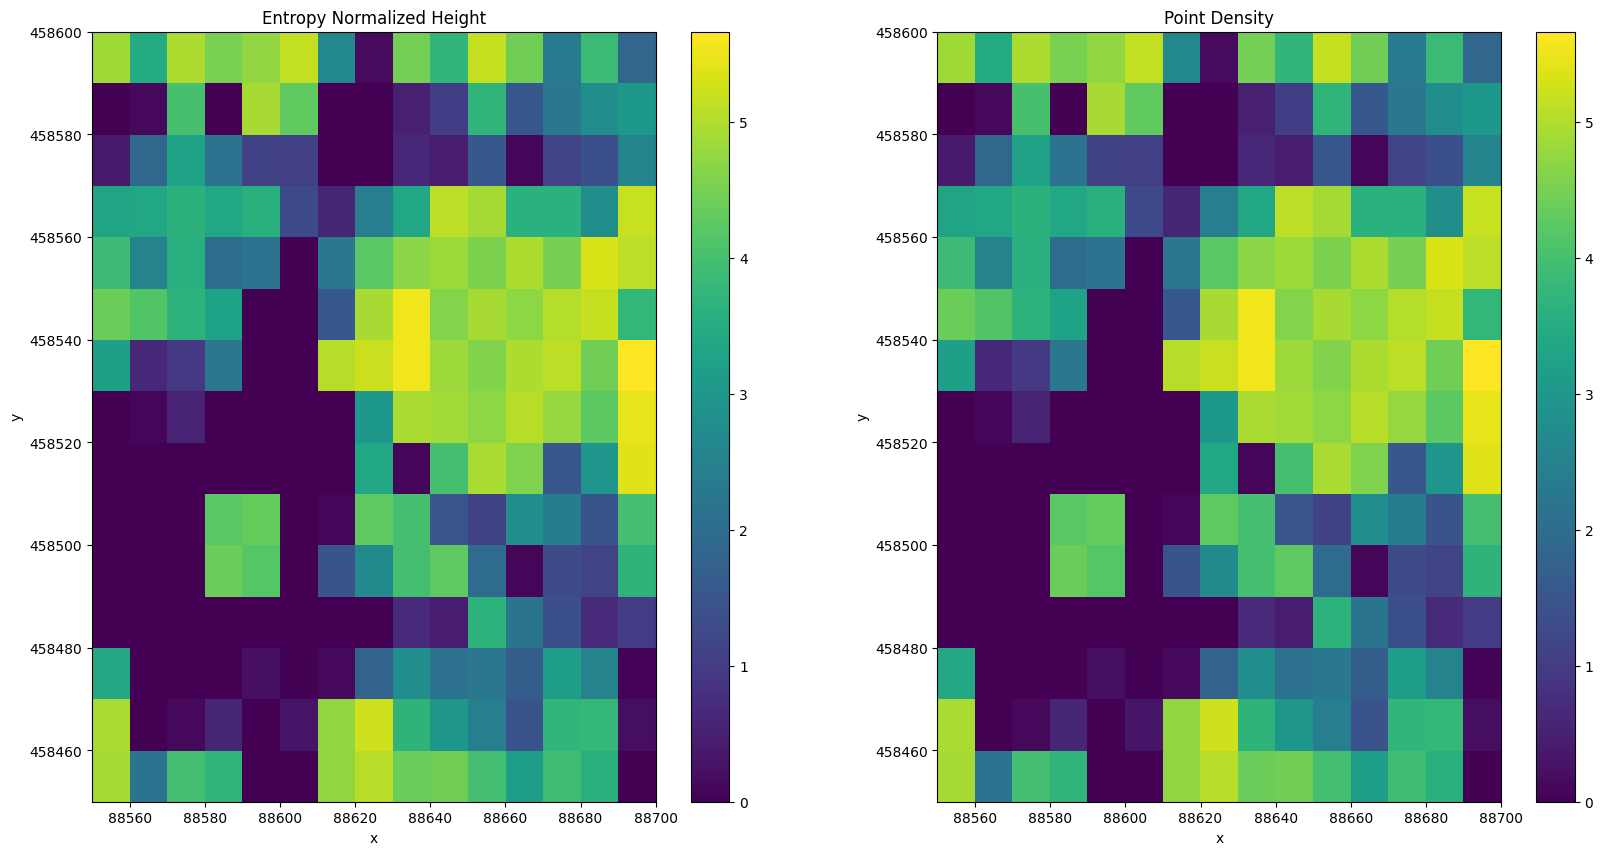

In [16]:
# import rasterio
import rioxarray
import xarray as xr
from matplotlib import pyplot as plt

f_height = 'geotiffs/geotiff_TILE_000_BAND_entropy_normalized_height.tif'
f_density = 'geotiff_TILE_000_BAND_point_density.tif' 
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
da = rioxarray.open_rasterio(f_height)
xr.plot.imshow(da[0])
plt.xlim([88550, 88700])
plt.ylim([458450, 458600])
plt.title('Entropy Normalized Height')


plt.subplot(1,2,2)
da = rioxarray.open_rasterio(f_height)
xr.plot.imshow(da[0])
plt.xlim([88550, 88700])
plt.ylim([458450, 458600])
plt.title('Point Density')

plt.show()

### Terminate cluster

At the end of this tutorial, the cluster can be closed by:

In [17]:
cluster.close()